In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mylifneuron as mln
from scipy.stats import poisson
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['lines.linewidth'] = 1.5

array([150.9, 163.9, 176.9, 189.9])

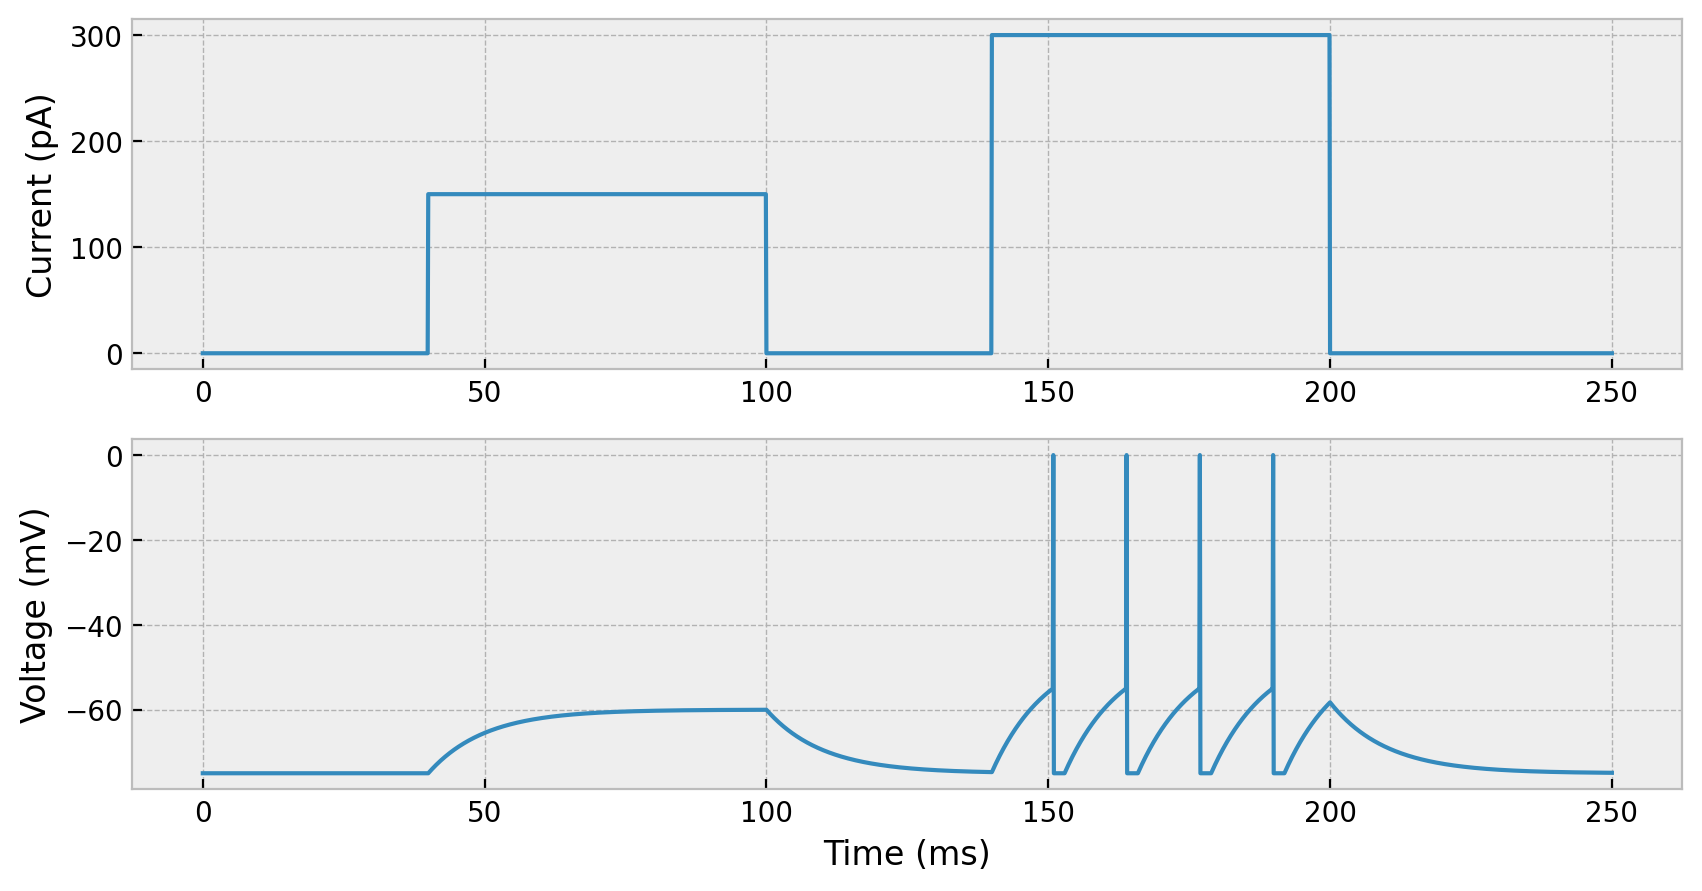

In [3]:
#simulate lif neuron and plot spike train
dt = 0.1  # (ms)
time = np.arange(0, 250+dt, dt) # (ms)
I = np.zeros(time.shape)  # (pA)
I[(time >= 40) & (time < 100)] = 150 
I[(time >= 140) & (time < 200)] = 300

V, spike_times = mln.simulation(I, dt)

mln.splot(time, I, V)
spike_times

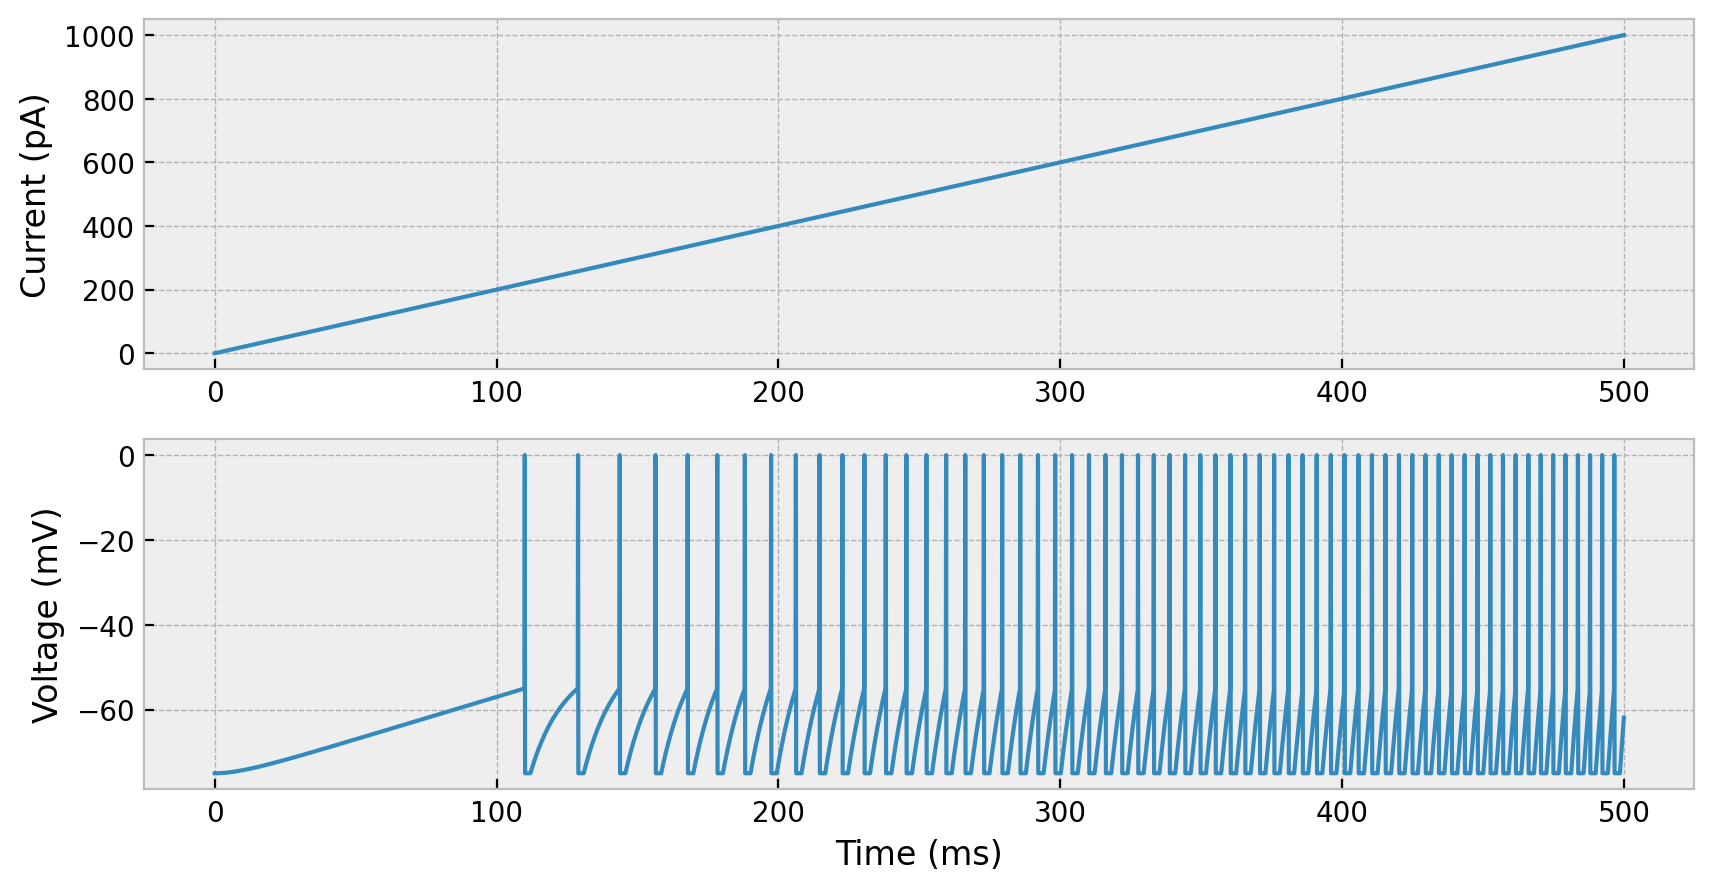

In [4]:
#Use the default LIF neuron parameters to simulate injecting a current ramp from 0 to 1000 pA over 500 ms.
dt = 0.1  # (ms)
time = np.arange(0, 500+dt, dt)
I = np.linspace(0, 1000, len(time))
V, spike_times = mln.simulation(I, dt)
mln.splot(time, I, V)

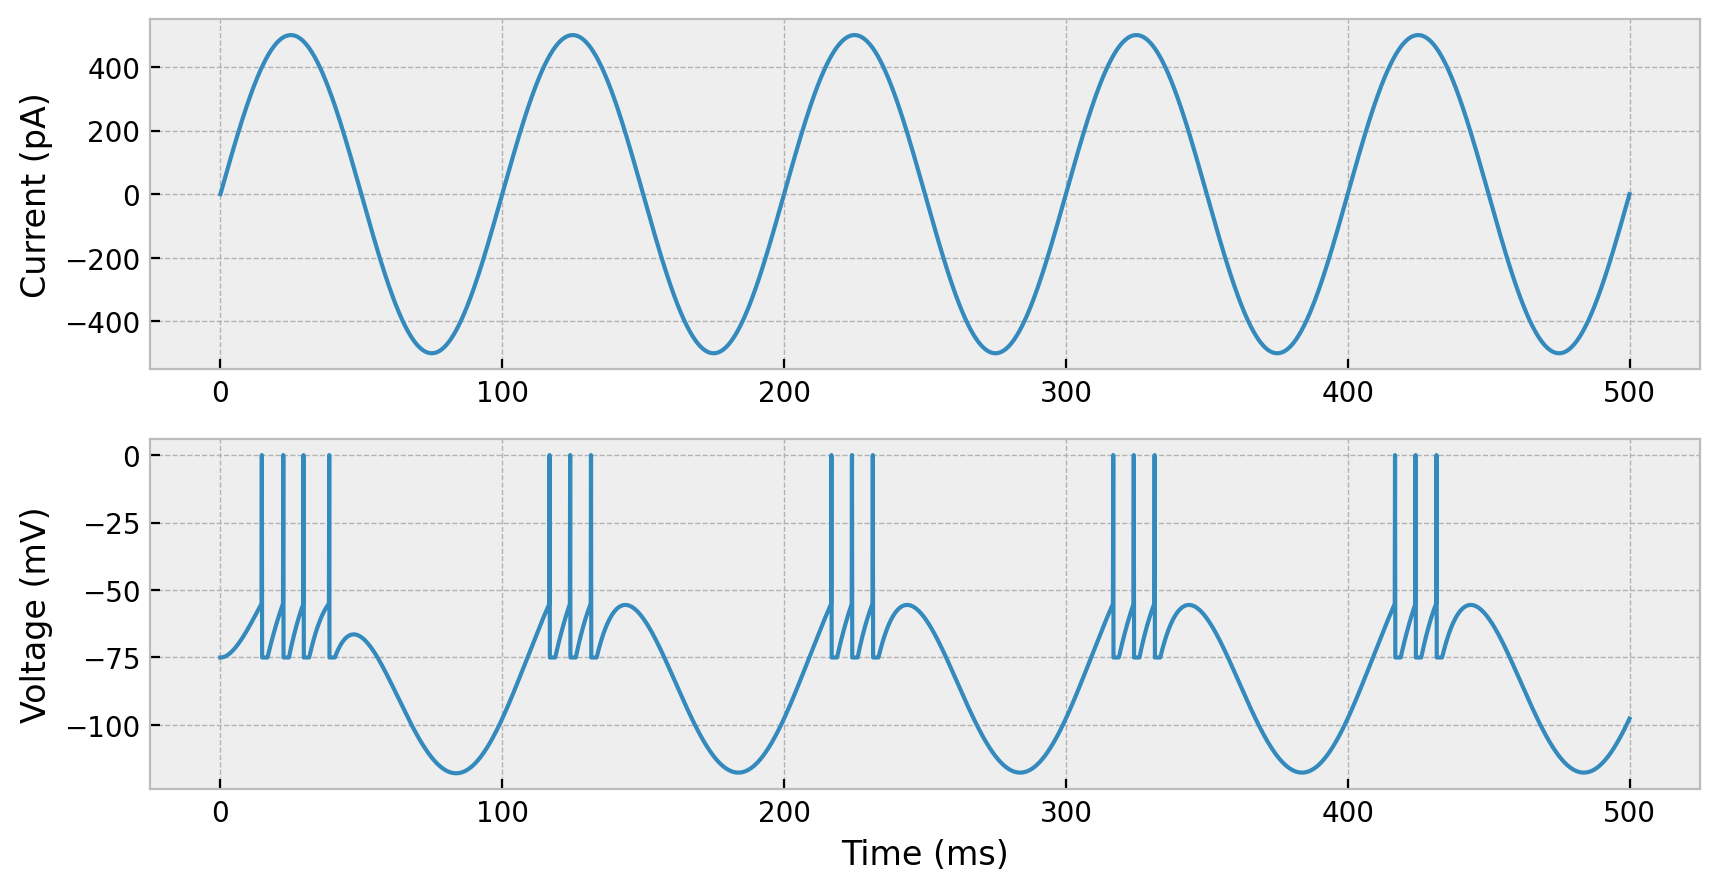

In [6]:
#Use the default LIF neuron parameters to simulate injecting five cycles of a sinusoidal current with amplitude 500 pA and cycle period 100 ms.
dt = 0.1  # (ms)
time = np.arange(0, 500+dt, dt)
I = 500 * np.sin(2 * np.pi / 100 * time)
V, spike_times = mln.simulation(I, dt)
mln.splot(time, I, V)

'Spike rate = 110.0 Hz'

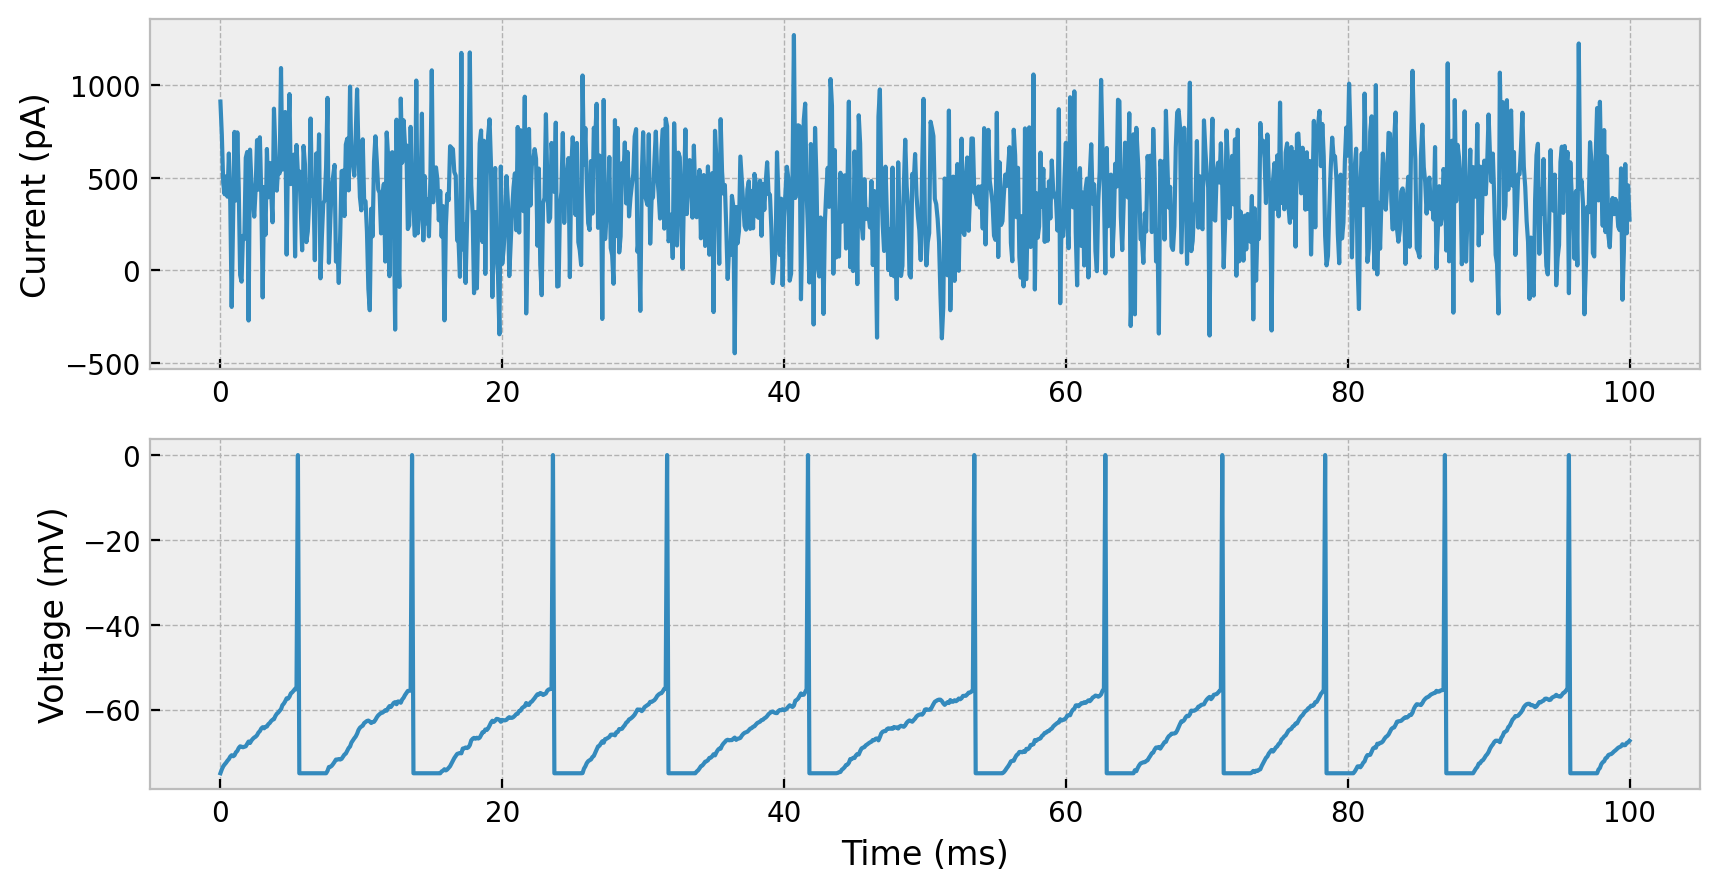

In [8]:
#Use the default LIF neuron parameters to simulate injecting a step current of 400 pA plus Gaussian noise 
#with a standard deviation of 300 pA for a duration of 100 ms. compute the neuron's spike rate from the simulation.
dt = 0.1  # (ms)
time = np.arange(0, 100+dt, dt)
I = 400 + 300 * np.random.randn(len(time))
V, spike_times = mln.simulation(I, dt)
mln.splot(time, I, V)
f"Spike rate = {len(spike_times) / 0.1 :.1f} Hz"

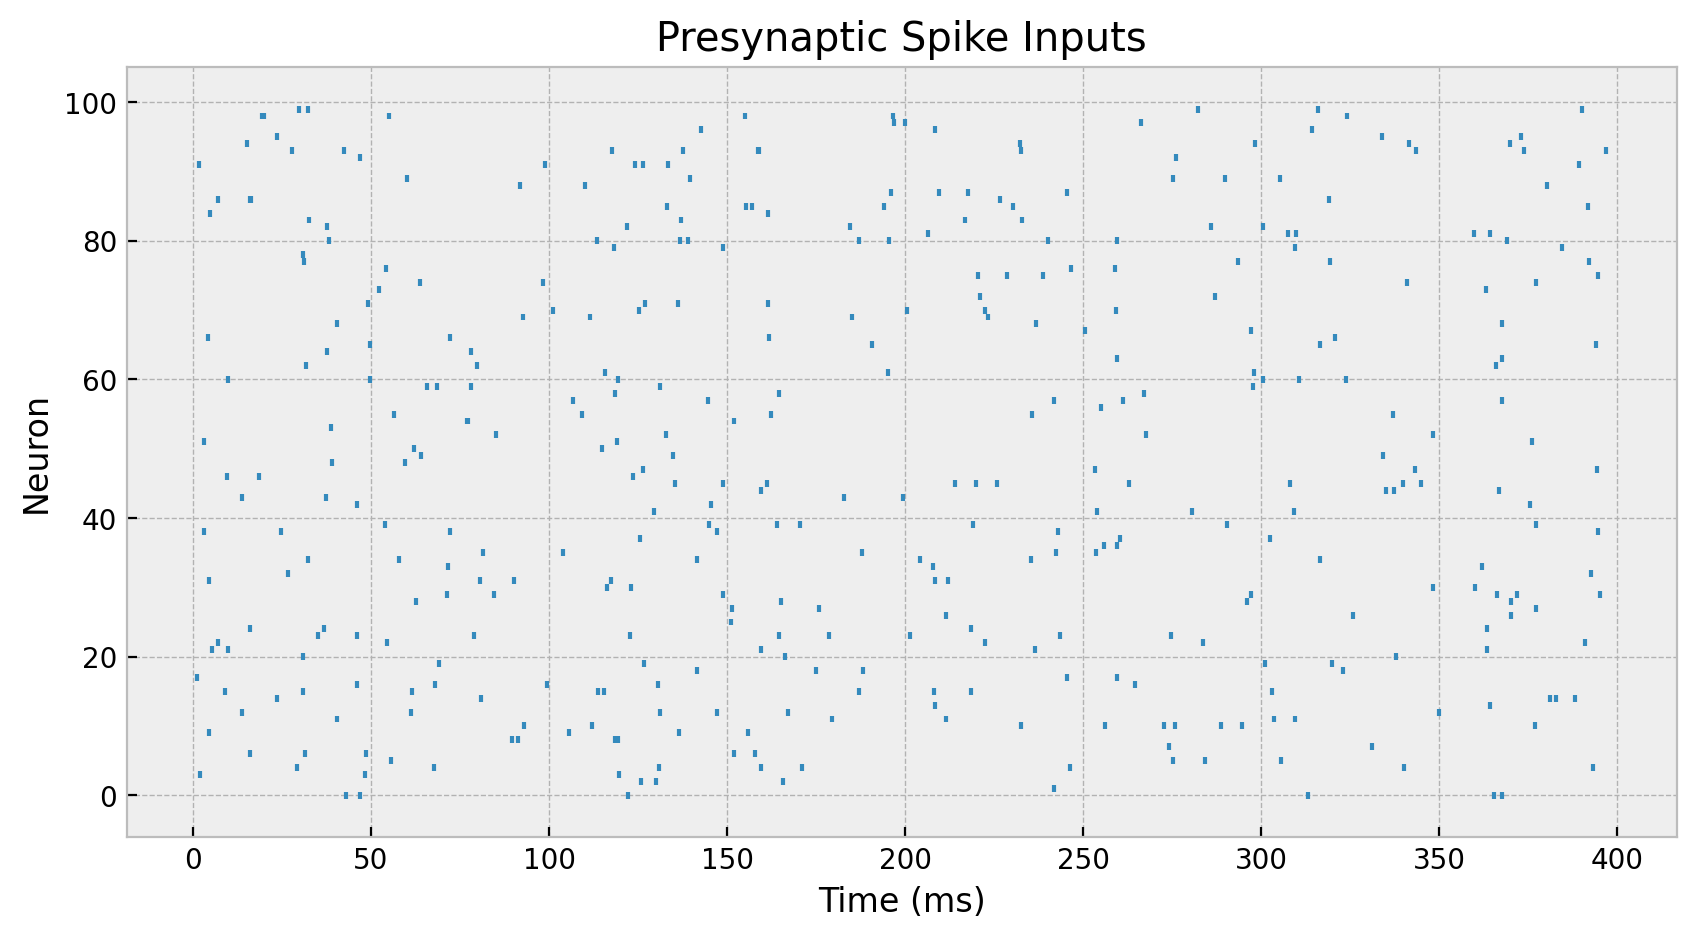

In [12]:
#the neuron is recieving input from other neurons via many synapses, with some portion of the synapses being excitatory and some inhibitory
#for simplification assume presynaptic firing rate of of 10 Hz.
#use a poisson distribution to simulate presynaptic spiking
# simulation time steps
dt = 0.1  # (ms)
time = np.arange(0, 400+dt, dt)

# presynaptic neurons average spike rate
n_neurons = 100
spike_rate = 10  # (Hz)

# average spike rate per time step
spike_rate_per_dt = spike_rate / 1000.0 * dt

# probabilities in [0,1) for each neuron (row) and each time point (column)
urand = np.random.uniform(0, 1, size=[n_neurons, len(time)])

# stochastic number of input spikes for each neuron (row) and each time point (column)
# For small spike_rate_per_dt this will mostly be zeros with one or a few spikes every now and then.
presynaptic_spikes = poisson.ppf(urand, spike_rate_per_dt)

# nested list of list of spike times for each neuron
spike_times = []
for i in range(n_neurons):
    spike_train = presynaptic_spikes[i]
    spike_times.append(time[spike_train > 0])

#create a raster plot of presynaptic spike train
plt.eventplot(spike_times)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')
plt.title('Presynaptic Spike Inputs');


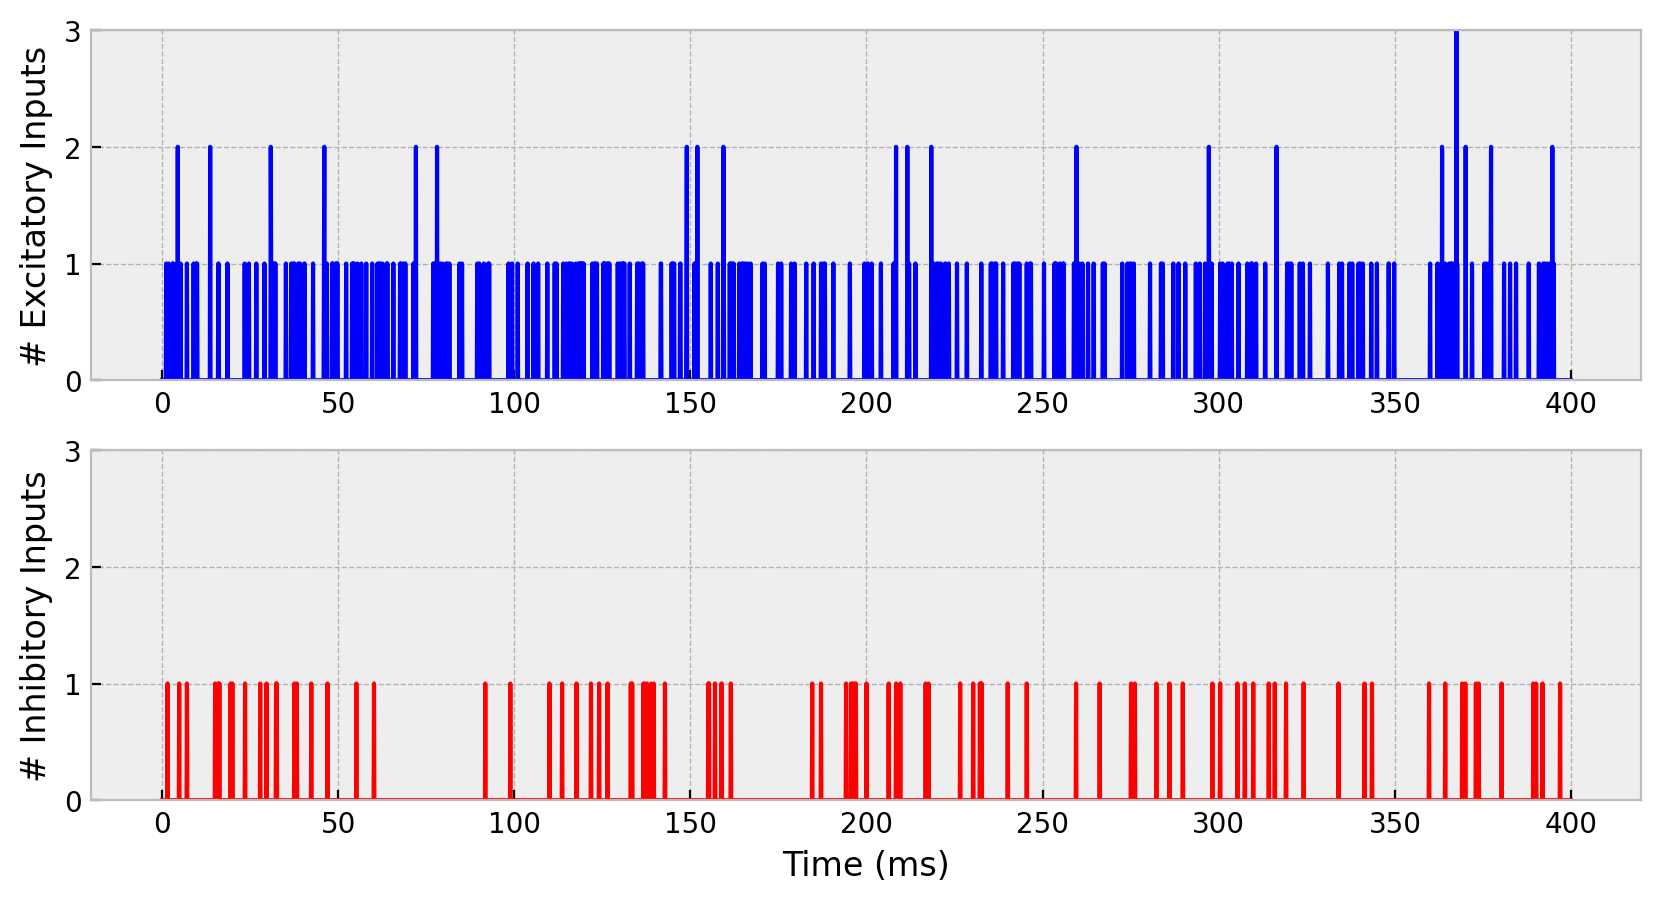

In [13]:
#split the 100 neurons and assume the first 80 are excitatory and the last 20 are inhibitory
excitatory_spikes = presynaptic_spikes[:80]
inhibitory_spikes = presynaptic_spikes[80:]

# total number of spikes from all input neurons per time step
NE = excitatory_spikes.sum(axis=0)
NI = inhibitory_spikes.sum(axis=0)

#plot presynaptic firing at each time step
plt.subplot(2, 1, 1)
plt.plot(time, NE, 'b', label='excitatory')
Nmax = max(NE.max(), NI.max())
plt.ylim([0, Nmax])
plt.yticks(np.arange(Nmax+1))
plt.ylabel('# Excitatory Inputs')
plt.subplot(2, 1, 2)
plt.plot(time, NI, 'r')
plt.ylim([0, Nmax])
plt.yticks(np.arange(Nmax+1))
plt.xlabel('Time (ms)')
plt.ylabel('# Inhibitory Inputs');

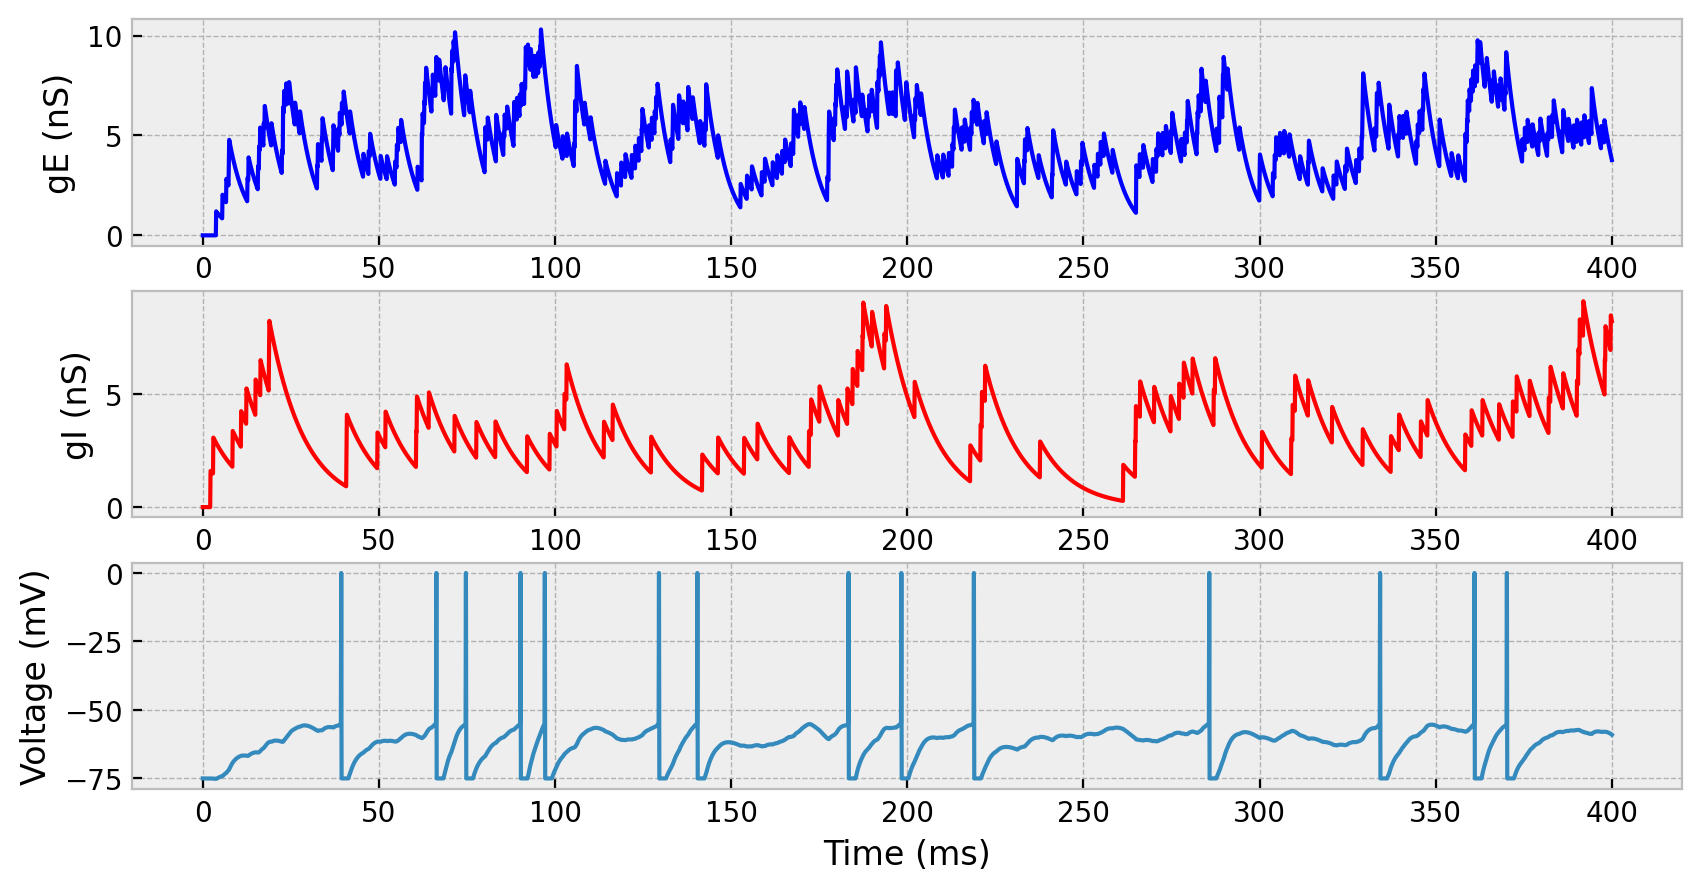

In [14]:
#simulate response to synaptic inputs
dt = 0.1  # (ms)
time = np.arange(0, 400+dt, dt)
n_neurons = 100
spike_rate = 10  # (Hz)
spike_rate_per_dt = spike_rate / 1000.0 * dt
presynaptic_spikes = poisson.ppf(np.random.uniform(0, 1, size=[n_neurons, len(time)]), spike_rate_per_dt)
excitatory_spikes = presynaptic_spikes[:80]
inhibitory_spikes = presynaptic_spikes[80:]
I = np.zeros(time.shape)  # no injected current

V, spike_times, gE, gI = mln.synaptic(dt, I, excitatory_spikes, inhibitory_spikes)

#plot the excitatory and inhibitory conductances
plt.subplot(3, 1, 1)
plt.plot(time, gE, 'b')
plt.ylabel('gE (nS)')
plt.subplot(3, 1, 2)
plt.plot(time, gI, 'r')
plt.ylabel('gI (nS)')
plt.subplot(3, 1, 3)
plt.plot(time, V)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)');

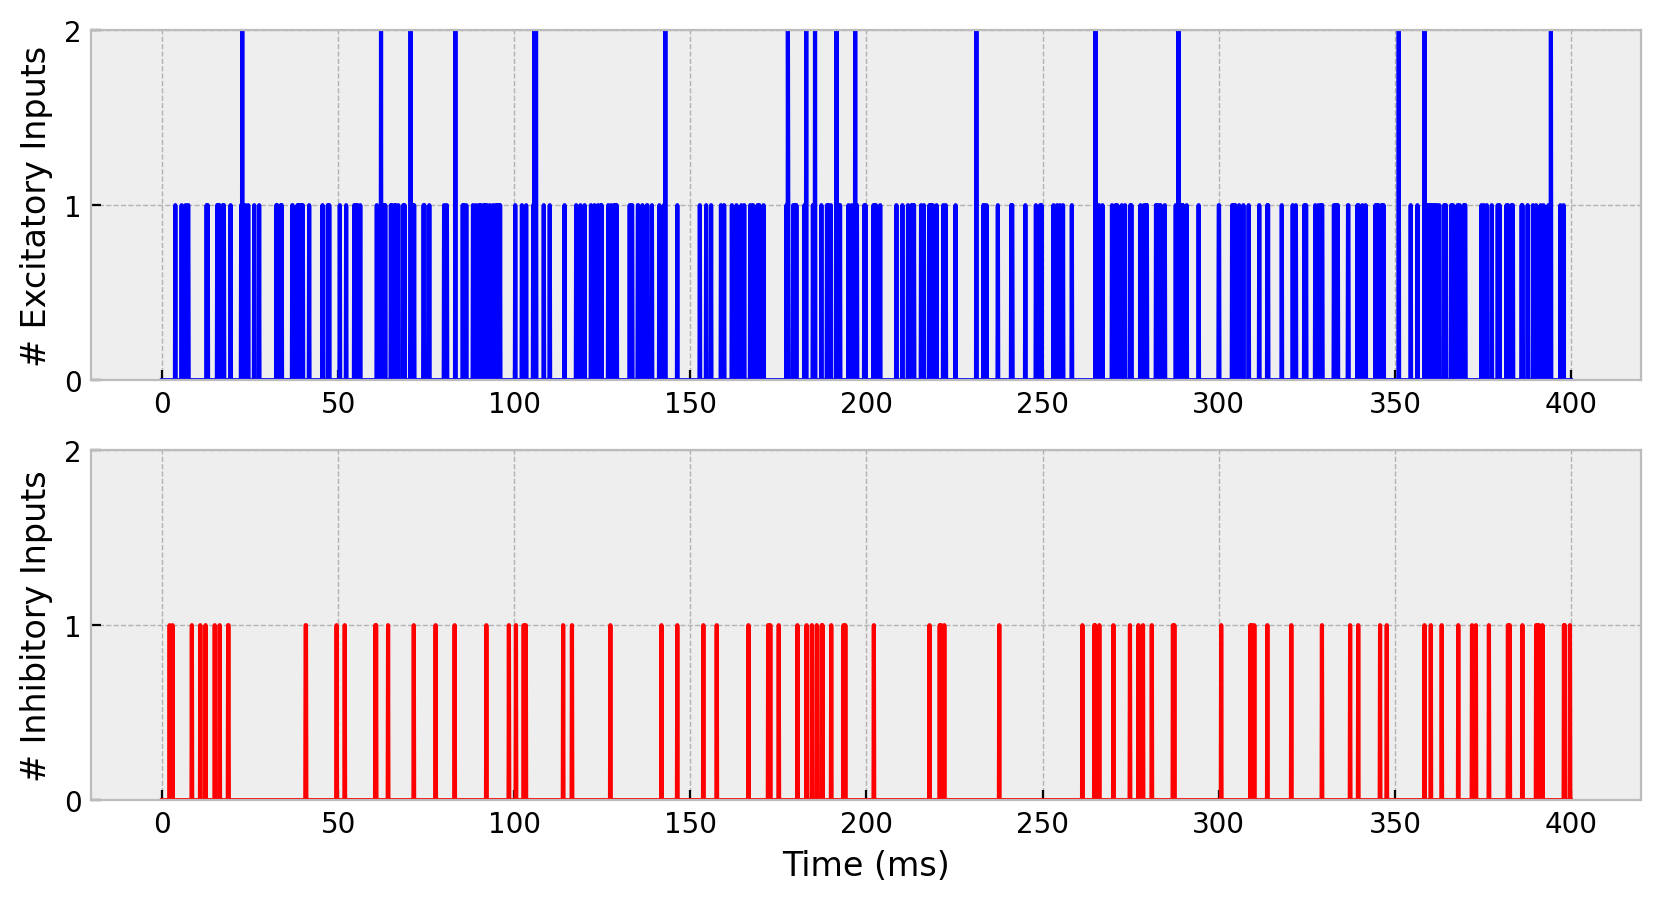

In [15]:
# total number of spikes from all input neurons per time step
NE = excitatory_spikes.sum(axis=0)
NI = inhibitory_spikes.sum(axis=0)

plt.subplot(2, 1, 1)
plt.plot(time, NE, 'b', label='excitatory')
Nmax = max(NE.max(), NI.max())
plt.ylim([0, Nmax])
plt.yticks(np.arange(Nmax+1))
plt.ylabel('# Excitatory Inputs')
plt.subplot(2, 1, 2)
plt.plot(time, NI, 'r')
plt.ylim([0, Nmax])
plt.yticks(np.arange(Nmax+1))
plt.xlabel('Time (ms)')
plt.ylabel('# Inhibitory Inputs');

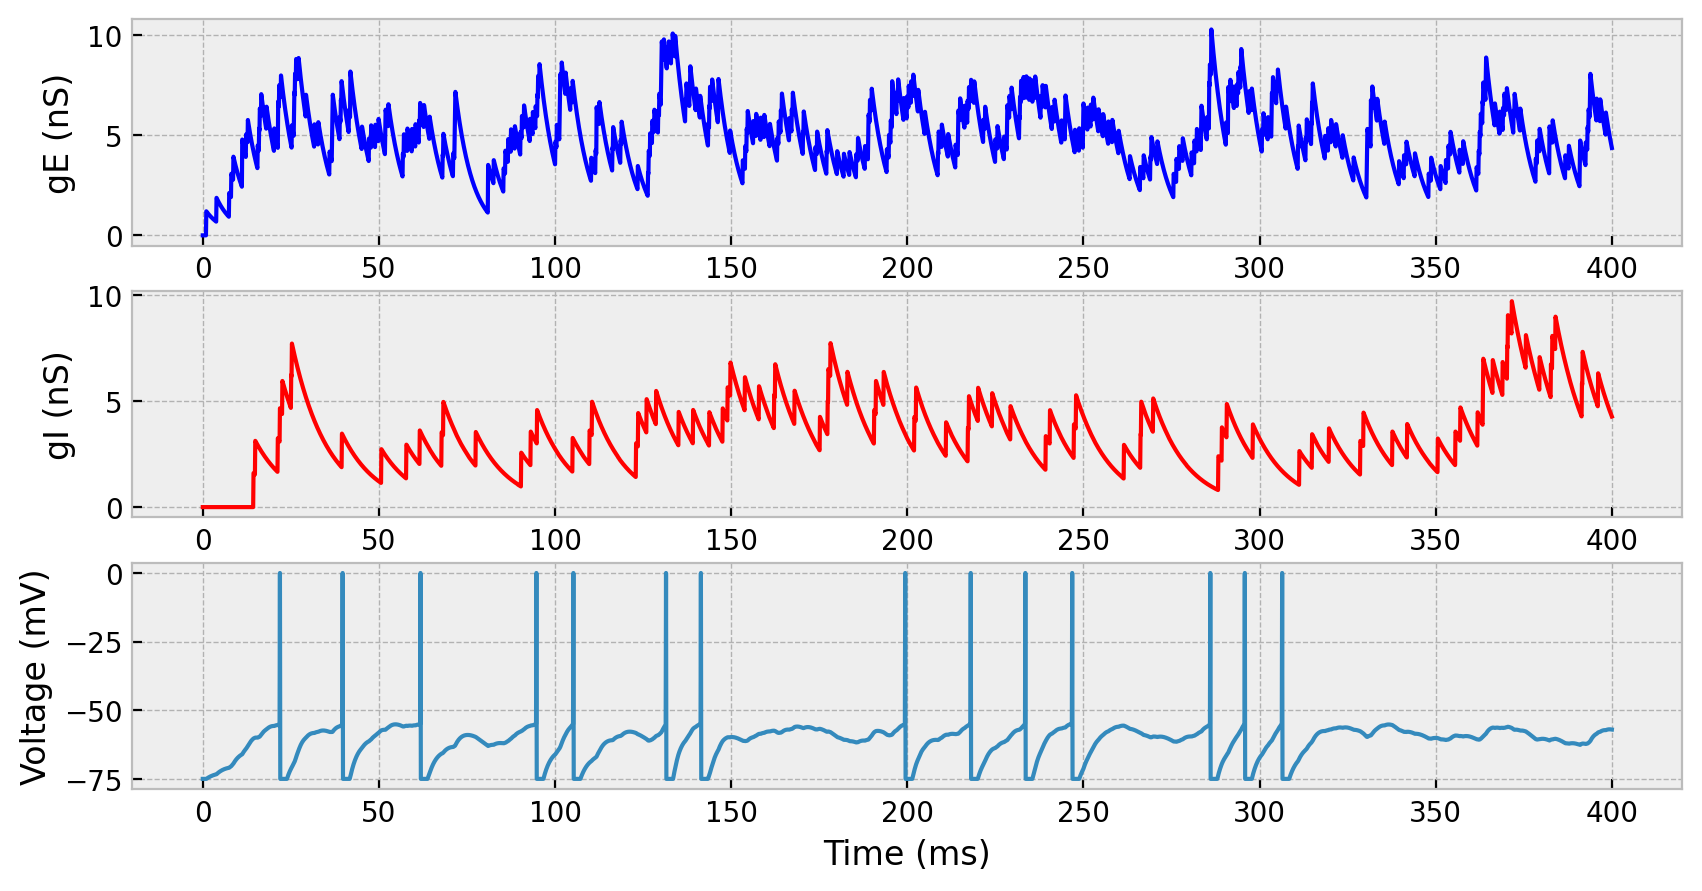

In [18]:
#Convolve the synaptic impulse response with the incoming spike train to get the excitatory and inhibitory conductance time series.
#redo the simulation to define synaptic conductances

# impulse response to each excitatory or inhibitory spike
sE=1.2
sI=1.6
tauE=5
tauI=10

t = np.arange(500) * dt

excitatory_spike_response = sE * np.exp(-t / tauE)
inhibitory_spike_response = sI * np.exp(-t / tauI)

#simulate neuron
dt = 0.1  # (ms)
time = np.arange(0, 400+dt, dt)
n_neurons = 100
spike_rate = 10  # (Hz)
spike_rate_per_dt = spike_rate / 1000.0 * dt
presynaptic_spikes = poisson.ppf(np.random.uniform(0, 1, size=[n_neurons, len(time)]), spike_rate_per_dt)
excitatory_spikes = presynaptic_spikes[:80]
inhibitory_spikes = presynaptic_spikes[80:]
I = np.zeros(time.shape)

V, spike_times, gE, gI = mln.synaptic_conv(dt, I, excitatory_spikes, inhibitory_spikes)

plt.subplot(3, 1, 1)
plt.plot(time, gE, 'b')
plt.ylabel('gE (nS)')
plt.subplot(3, 1, 2)
plt.plot(time, gI, 'r')
plt.ylabel('gI (nS)')
plt.subplot(3, 1, 3)
plt.plot(time, V)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)');